**Задание**

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

В качестве входных данных Вы имеете 4 csv-файла:
 - `groups.csv` - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
 - `groups_add.csv` - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
 - `active_studs.csv` - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
 - `checks.csv` - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

*Предлагаем Вам ответить на следующие вопросы:*
На какие метрики Вы смотрите в ходе анализа и почему?
Имеются ли различия в показателях и с чем они могут быть связаны?
Являются ли эти различия статистически значимыми?
Стоит ли запускать новую механику на всех пользователей?

##  EDA (Исследовательский анализ данных)
    

In [1]:
# Импортирую библиотеки и задам настройки отображения
import pandas as pd
import requests
from urllib.parse import urlencode
import pandahouse as ph

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
import numpy as np

import scipy.stats as stats
from scipy.stats import norm

sns.set(
    style="whitegrid",
    rc={'figure.figsize': (20, 7)})
pd.set_option('display.precision', 2)

In [2]:
# использование api 
def url(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    final_url = base_url + urlencode(dict(public_key=public_key))
    response_active = requests.get(final_url)
    download_url = response_active.json()['href']
#   download_response = requests.get(download_url)
    return download_url

In [3]:
download_url_active_studs = url('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ' )
active = pd.read_csv(download_url_active_studs)
download_url_checks = url('https://disk.yandex.ru/d/pH1q-VqcxXjsVA')
checks = pd.read_csv(download_url_checks, sep=';')
download_url_groups = url('https://disk.yandex.ru/d/UhyYx41rTt3clQ' )
groups = pd.read_csv(download_url_groups, sep=';')
download_url_group_add = url('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ')
group_add = pd.read_csv(download_url_group_add)

Датафрейм `groups` содержит данные о распределении пользователей по группам. В датафрейме 74 484 строки, все значения id уникальны. Максимальное значение id 5694419. 

In [4]:
groups = groups.rename(columns={'id': 'student_id', 'grp': 'group'})

print(f' Количество уникальных пользователей {groups.student_id.nunique()}')
print(f' Максимальный идентификатор пользователя {groups.student_id.max()}')
groups.head(1)

 Количество уникальных пользователей 74484
 Максимальный идентификатор пользователя 5694419


,student_id,group
0,1489,B


Датафрейм `active` содержит данные (id) о пользователях, которые были активны во время проведения А/Б-тестирования. В датафрейме 8 341 строка и столько же уникальных значений. Максимальное значение id пользователя 5951797, что больше, чем в таблице `groups`, следовательно  не все пользователи будут определены в группы. В связи с этим отправлен запрос о доп данных (`group_add`), которые по условиям задачи будут получены только через два дня. Следовательно, на данный момент нужно начинать анализ без них, а в дальнейшем составить функцию, которая добавит новые данные и рассчитает показатели.

In [5]:
print(f' Количество уникальных пользователей {active.student_id.nunique()}')
print(f' Максимальный идентификатор пользователя {active.student_id.max()}')
active.head(1)

 Количество уникальных пользователей 8341
 Максимальный идентификатор пользователя 5951797


,student_id
0,581585


Чтобы определить сколько пользователей остались без группы, к датафрейму `active` добавим информацию о группах из датафрейма `groups` и отфильтруем id пользователей без групп. Мы видим, что все значения больше 5694419 (максимального в датафрейме `groups`), следовательно мы можем предположить, что получили просто необновленную версию `groups` и данная ошибка не является результатом сбоя.

In [6]:
check_group = active.merge(groups, how='left', on='student_id')
check_group[check_group['group'].isnull()]

,student_id,group
1,5723133,NaN
111,5951797,NaN
632,5730382,NaN
2662,5739944,NaN
3830,5945085,NaN
4900,5700613,NaN
5254,5729371,NaN
5746,5777081,NaN
7413,5740903,NaN
7505,5760471,NaN


Датафрейм `checks` содержит данные об оплатах пользователей в период тестирования. В датафрейме 541 строка с уникальными id пользователя. Мы опять же видим, что максимальный идентификатор пользователя больше, чем в таблице `groups`. Проверим номера пользователей без группы. Опять же это только номер свыше максимального, то есть причина та же и до получения обновленных данных я использую те, что имеются.

In [7]:
print(f' Количество уникальных пользователей, совершивших покупку в период проведения тестирования {checks.student_id.nunique()}')
print(f' Максимальный идентификатор пользователя {checks.student_id.max()}')
print(f' Сумма выручки за период проведения тестирования {checks.rev.sum().round(0)} RUB')
checks.head(1)

 Количество уникальных пользователей, совершивших покупку в период проведения тестирования 541
 Максимальный идентификатор пользователя 5740903
 Сумма выручки за период проведения тестирования 573326.0 RUB


,student_id,rev
0,1627,990.0


In [8]:
check_group_2 = checks.merge(groups, how='left', on='student_id')
check_group_2[check_group_2['group'].isnull()]

,student_id,rev,group
540,5740903,1900.0,NaN


Проверив, сколько пользователей из датафрейма `checks` не присутствуют в датафрейме `active`, видим, что это 149 человек с выручкой 105 532р.(~20% от общей выручки по датафрейму `checks`)
Можно предположить два объяснения этому факту:
 - эти платежи не имеют отношения к эсперименту и являются автоматическим продлением подписки, то есть при осуществлении данных платежей пользователям вообще не демонстрировалась никакая система оплаты.
 - данные пользователи по ошибке не попали в список активных пользователей.
 
Так как доля "неопознанной" выручки значительна, то посчитаю показатели по обоим вариантам. В последствии, выяснив причины можно будет выбрать более подходящий.

In [9]:
only_checks = pd.merge(checks, active, how='outer', on='student_id', indicator=True).query('_merge == "left_only"')
only_checks

,student_id,rev,_merge
1,3185,690.0,left_only
2,25973,690.0,left_only
3,26280,690.0,left_only
5,100645,630.0,left_only
6,102534,580.0,left_only
...,...,...,...
508,5291900,199.0,left_only
512,5331842,290.0,left_only
521,5486319,199.0,left_only
530,5562806,398.0,left_only


Посмотрим какие суммы чеков есть в таблице. Видим небольшую погрешность в записи 1900.0001, что означает 1900. Сделаем замену, для чистоты данных. Видим, что самый популярный чек 1900.

In [10]:
display(checks.rev.unique())
checks = checks.replace(1900.0001, 1900.)
checks.groupby('rev', as_index=False).agg({'student_id': 'count'}).sort_values('student_id', ascending=False).head(5)

array([ 990.    ,  690.    ,  630.    ,  580.    ,  290.    , 1140.    ,
       1900.0001,  199.    ,  398.    , 1830.    , 1900.    , 3260.    ,
       2910.    , 2820.    , 2099.    , 3660.    , 1530.    , 2900.    ,
       1980.    , 1160.    ,  870.    ,  840.    , 2890.    , 1180.    ,
        880.    , 3040.    ,  796.    , 4650.    , 2190.    , 1729.    ,
       1388.    ,  590.    , 2220.    ,  489.    , 1050.    , 1968.    ,
       1339.    ,  597.    , 1039.    ])

,rev,student_id
24,1900.0,133
1,290.0,94
8,690.0,78
0,199.0,46
13,990.0,41


Построим график распределения сумм чеков. Выделяется чек с суммой 1900. Это может означать, что проводилась какая-то акция, которая была направлена на продвижение данной покупки.

<bound method Artist.set of <matplotlib.axes._subplots.AxesSubplot object at 0x7ffa1195cda0>>

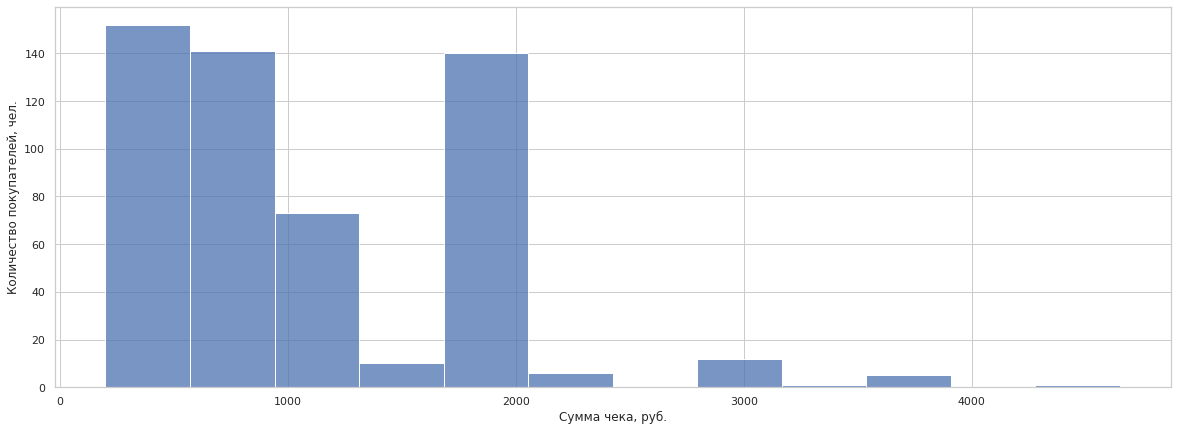

In [11]:
ax = sns.histplot(data=checks, x="rev")
ax.set_xlabel('Сумма чека, руб.')
ax.set_ylabel('Количество покупателей, чел.')
ax.set

Далее, как было обозначено выше буду двигаться по двум вариантам: 1. оценивать участие в эксперименте только пользователей из таблицы `active` 2. оценивать участие в эксперименте всех пользователей, совершивших покупку.
Сначала первый вариант. Соберем все данные в общую таблицу и удалим пользователей без групп, так как в дальнейшем планирую получить данные и добавить их.

In [12]:
total_active = active.merge(checks, how='left', on='student_id')
total_active = total_active.merge(groups, how='left', on='student_id')

In [13]:
total_active = total_active.dropna(subset=['group'])
total_active['pay'] = total_active['rev'].apply(lambda x: 1 if x > 0 else 0)

Для второго варианта (все пользователи из таблицы `checks` принимали участие в эксперименте) соберем все данные в общую таблицу. Чтобы удостовериться, что записи из `checks` не потеряны, проверяю общую сумму выручки.Далее проставим пользователям группы согласно `groups` и удалим пользователей без группы, по ним информация будет позже.

In [14]:
total_checks = active.merge(checks, how='outer', on='student_id')
print(f' Общая сумма выручки {total_checks.rev.sum().round(0)} РУБ')
total_checks = total_checks.merge(groups, how='left', on='student_id')
total_checks.head(1)

 Общая сумма выручки 573326.0 РУБ


,student_id,rev,group
0,581585,NaN,A


In [15]:
total_checks = total_checks.dropna(subset=['group'])
total_checks['pay'] = total_checks['rev'].apply(lambda x: 1 if x > 0 else 0)

##  А/B-тест

При проведении A/B-тестирования выполняются следующие шаги:
1. Выдвигается нулевая гипотеза: при введении новой механики оплаты услуг конверсия в покупку не изменится.
2. Переменная: новая механика оплаты услуг.
3. Метрика: конверсия в покупку. Я выбрала данную метрику, потому что изменение механики оплаты в большей степени направлено на увеличение количества переходов в оплату (например, за счет упрощения процесса оплаты или изменения дизайна на более привлекательный). 
4. Объем выборки и статистическая достоверность. Для расчета необходимого объема выборки не хватает некоторых значимых показателей, поэтому примем за данность, что необходимый объем выборки был посчитан планировщиками эксперимента и был достигнут. Далее рассчитаем статистическую достоверность.

**Первый вариант: в эксперименте участвовали только пользователи из списка активных пользователей.**

Рассчитаю некоторые показатели тестовой(В) и контрольной(А) групп. 
Сразу бросается в глаза большой размер тестовой группы по сравнению с контрольной. Я бы рекомендовала применить другой подход в системе сплитования. Как я поняла, пользователи были разделены на группы заранее, по факту регистрации и каким-то образом (возможно случайно), более активные в последние дни пользователи попали в тестовую группу. Для более равномерного распределения на группы можно использовать распределение в группу в момент входа на сайт (нечетные в контрольную, четные - в тестовую, для распределения 50/50, например. Можно определить и другой размер для тестовой группы и в другой пропорции распределять пользователей).

In [16]:
share_active = total_active.groupby(['group'], as_index=False)\
                           .agg({'rev': 'sum', 'student_id': 'count'})\
                           .rename(columns={'student_id': 'size'}).round(0)
share_active['pay'] = total_active.query('pay == 1').groupby('group', as_index=False).nunique()['student_id']
share_active['not_pay'] = share_active['size'] - share_active['pay']
share_active['ARPU'] = (share_active['rev'] / share_active['size'])
share_active['ARPPU'] = (share_active['rev'] / total_active.query('pay == 1')
                         .groupby('group', as_index=False)['student_id']\
                         .nunique()['student_id'])
share_active['CR'] = (share_active['pay'] / share_active['size'])

display(share_active.rename(columns={'group': 'Группа', 
                                     'rev': 'Выручка, руб',
                                     'size': 'Число пользователей',
                                     'pay': 'Число платящих пользователей',
                                     'not_pay': 'Число неплатящих пользователей',        
                                     'ARPU': 'Средний чек, руб', 
                                     'ARPPU': 'Средний чек на платящего пользователя, руб',
                                     'CR': 'Конверсия в покупку, пп'}))

,Группа,"Выручка, руб",Число пользователей,Число платящих пользователей,Число неплатящих пользователей,"Средний чек, руб","Средний чек на платящего пользователя, руб","Конверсия в покупку, пп"
0,A,72820.0,1535,78,1457,47.44,933.59,0.05
1,B,393074.0,6793,313,6480,57.86,1255.83,0.05


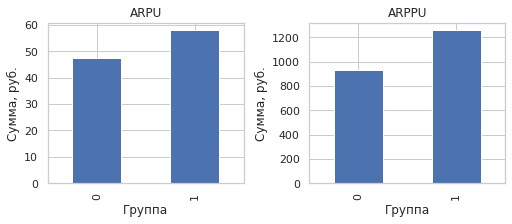

In [17]:
fg = plt.figure(figsize=(7, 3), constrained_layout=True)
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fg)
fig_ax_1 = fg.add_subplot(gs[0, 0])
share_active.ARPU.plot.bar()
plt.title("ARPU")
plt.xlabel("Группа")
plt.ylabel("Сумма, руб.")

fig_ax_2 = fg.add_subplot(gs[0, 1])
ax2 = share_active.ARPPU.plot.bar()
plt.title("ARPPU")
plt.xlabel("Группа")
plt.ylabel("Сумма, руб.")

plt.show()

Оценю статистическую значимость результатов. Так как конверсия является качественным показателем, то для проверки использую критерий Хи-квадрат.
Расчеты показывают, что при верности нулевой гипотезы вероятность получить значение конверсии как в тестовой группе или с меньшим отклонением от контрольной составляет 43%. Данное значение вероятности не позволяет нам отклонить нулевую гипотезу, следовательно для имеющихся данных мы считаем отклонение в конверсии в покупку при изменении механики оплаты несущественным.

In [18]:
group_A = list(share_active[['not_pay', 'pay']].loc[0])
group_B = list(share_active[['not_pay', 'pay']].loc[1])


# тест Хи-квадрат
chi2, p, dof, ex = stats.chi2_contingency([group_A, group_B], correction=False)

# Рассчитаю доверительный интервал для изменения
lift = (group_B[1] / group_B[0]) / (group_A[1] / group_A[0])
std_error = np.sqrt(1 / group_B[0] + 1 / group_B[1] + 1 / group_A[0] + 1 / group_A[1])
ci = stats.norm.interval(0.95, loc=lift, scale=std_error)

# Вывод результатов

print(f"Хи-квадрат p-value, %: {p*100:.2f}")
print("Доверительный интервал изменения в лямбдах:", ci)

# Проверяем есть ли изменение
if p < 0.05 and ci[0] > 1:
    print("Есть основания для отклонения нулевой гипотезы")
else:
    print("Не обнаружено оснований для отклонения нулевой гипотезы")

Хи-квадрат p-value, %: 42.81
Доверительный интервал изменения в лямбдах: (0.6478014558934166, 1.156729250026178)
Не обнаружено оснований для отклонения нулевой гипотезы


Вижу значительные отклонения по средним чекам. С учетом того, что есть "популярный" чек, посмотрю как распределились чеки по группам. По графику можно увидеть, что "популярный" чек был только в тестовой группе, а в контрольной распределение чеков более ожидаемое (с меньшей суммой больше чеков). Из этого можно сделать вывод, что эксперимент не был "чистым". Помимо механики оплаты были внесены другие изменения на стадии выбора покупки, о чем не было сообщено в исходной задаче. 

Text(0, 0.5, 'Количество покупателей, чел.')

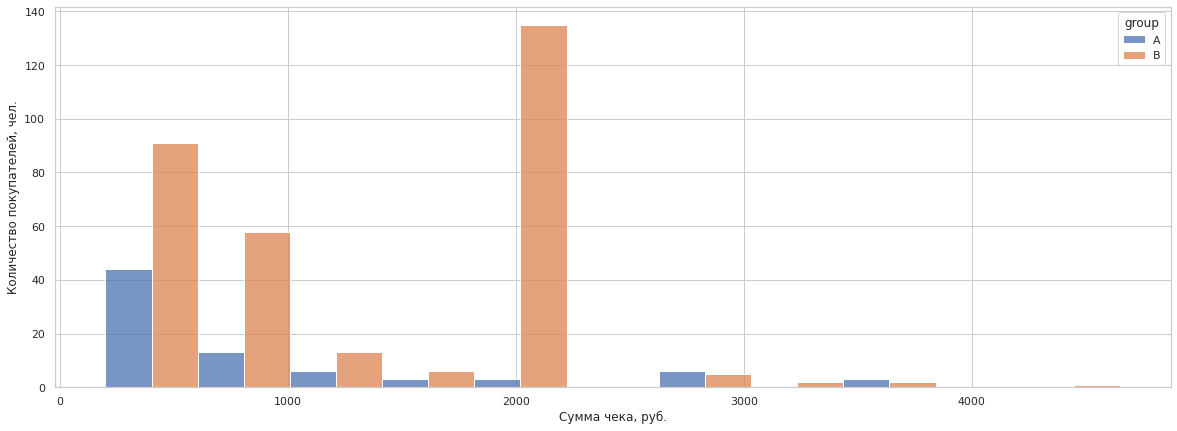

In [19]:
ax = sns.histplot(data=total_active, x="rev", multiple='dodge', hue='group')
ax.set_xlabel('Сумма чека, руб.')
ax.set_ylabel('Количество покупателей, чел.')

Справочно исследую насколько статистически значимы изменения в среднем чеке и в среднем чеке на платящего пользователя. Так как я не знаю какие изменения были внесены для А/Б-тестирования, то затрудняюсь адекватно оценить какой показатель использовать для оценки эффективности изменений. 
На мой взгляд, если изменения были предложены после принятия решения пользователем о покупке, то оценивать нужно средний чек на платящего пользователя. Если же изменения были видны всем пользователям, то я бы оценивала средний чек на пользователя.

Для оценки статистической достоверности средних в независимых группах использую t-критерий Стьюдента. Так как группы достаточно большие, то не проверяю их на гомогенность и нормальность.

In [20]:
# Средний чек на пользователя
total_a = total_active.fillna(0)
a = total_a.query('group=="A"')['rev']
b = total_a.query('group=="B"')['rev']
stats.ttest_ind(a, b)

Ttest_indResult(statistic=-1.1930593769039888, pvalue=0.23288011573839099)

In [21]:
# Средний чек на платящего пользователя
a = total_a.query('group=="A" & pay==1')['rev']
b = total_a.query('group=="B" & pay==1')['rev']
stats.ttest_ind(a, b)

Ttest_indResult(statistic=-3.111438899996839, pvalue=0.001999178560469943)

По результатам тестирования можно сказать, что средний чек на пользователя не изменился статистически значимо (p-value = 0.233), следовательно нет оснований отвергать гипотезу, что новый механизм не влияет на величину среднего чека. Средний чек на платящего пользователя изменился статистически значимо (p-value = 0.002), следовательно есть основания отвергнуть гипотезу, что новый механизм не влияет на величину среднего чека платящего пользователя.

**Второй вариант: в эксперименте участвовали все пользователи, совершившие покупку.**

Аналогично первому варианту рассчитаю все показатели, пояснения дублировать не буду.

In [22]:
share_checks = total_checks.groupby(['group'], as_index=False)\
                           .agg({'rev': 'sum', 'student_id': 'count'})\
                           .rename(columns={'student_id': 'size'}).round(0)
share_checks['pay'] = total_checks.query('pay == 1').groupby('group', as_index=False).nunique()['student_id']
share_checks['not_pay'] = share_checks['size'] - share_checks['pay']
share_checks['ARPU'] = (share_checks['rev'] / share_checks['size'])
share_checks['ARPPU'] = (share_checks['rev'] / total_checks.query('pay == 1')
                         .groupby('group', as_index=False)['student_id']\
                         .nunique()['student_id'])
share_checks['CR'] = (share_checks['pay'] / share_checks['size'])

display(share_checks.rename(columns={'group': 'Группа', 
                                     'rev': 'Выручка, руб',
                                     'size': 'Число пользователей',
                                     'pay': 'Число платящих пользователей',
                                     'not_pay': 'Число неплатящих пользователей',        
                                     'ARPU': 'Средний чек, руб', 
                                     'ARPPU': 'Средний чек на платящего пользователя, руб',
                                     'CR': 'Конверсия в покупку, пп'}))

,Группа,"Выручка, руб",Число пользователей,Число платящих пользователей,Число неплатящих пользователей,"Средний чек, руб","Средний чек на платящего пользователя, руб","Конверсия в покупку, пп"
0,A,92096.0,1564,107,1457,58.88,860.71,0.07
1,B,479330.0,6913,433,6480,69.34,1107.00,0.06


In [23]:
group_A = list(share_checks[['not_pay', 'pay']].loc[0])
group_B = list(share_checks[['not_pay', 'pay']].loc[1])


# тест Хи-квадрат
chi2, p, dof, ex = stats.chi2_contingency([group_A, group_B], correction=False)

# Рассчитаю доверительный интервал для изменения
lift = (group_B[1] / group_B[0]) / (group_A[1] / group_A[0])
std_error = np.sqrt(1 / group_B[0] + 1 / group_B[1] + 1 / group_A[0] + 1 / group_A[1])
ci = stats.norm.interval(0.95, loc=lift, scale=std_error)

# Вывод результатов

print(f"Хи-квадрат p-value, %: {p*100:.2f}")
print("Доверительный интервал изменения в лямбдах:", ci)

# Проверяем есть ли изменение
if p < 0.05 and ci[0] > 1:
    print("Есть основания для отклонения нулевой гипотезы")
else:
    print("Не обнаружено оснований для отклонения нулевой гипотезы")

Хи-квадрат p-value, %: 39.81
Доверительный интервал изменения в лямбдах: (0.6907946007691652, 1.1289844461905671)
Не обнаружено оснований для отклонения нулевой гипотезы


Text(0, 0.5, 'Количество покупателей, чел.')

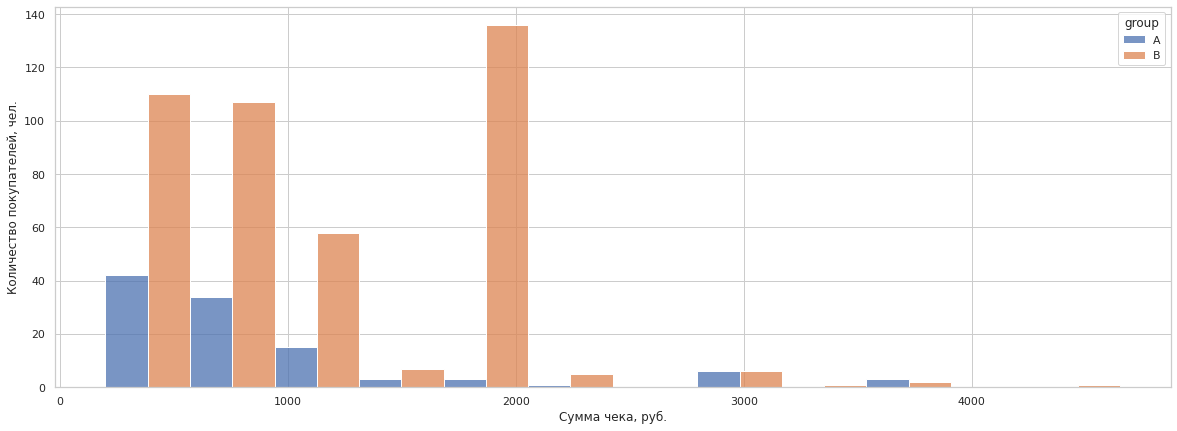

In [24]:
ax = sns.histplot(data=total_checks, x="rev", multiple='dodge', hue='group')
ax.set_xlabel('Сумма чека, руб.')
ax.set_ylabel('Количество покупателей, чел.')

In [25]:
# Средний чек на пользователя
total_c = total_checks.fillna(0)
a = total_c.query('group=="A"')['rev']
b = total_c.query('group=="B"')['rev']
stats.ttest_ind(a, b)

Ttest_indResult(statistic=-1.1588256471664464, pvalue=0.24655991175593625)

In [26]:
# Средний чек на платящего пользователя
a = total_c.query('group=="A" & pay==1')['rev']
b = total_c.query('group=="B" & pay==1')['rev']
stats.ttest_ind(a, b)

Ttest_indResult(statistic=-3.013977694702081, pvalue=0.0026999939486410294)

### Выводы и рекомендации <a name="subparagraph1"></a>

Было проведено А/В-тестирование для проверки следующей нулевой гипотезы: при введении новой механики оплаты услуг конверсия в покупку не изменится. 
Для оценки статистической значимости результатов использовался критерий Хи-квадрат.

С учетом полученной мной информации, я бы рекомендовала остановить A/B-тестирование в связи с тем, что:
 - Система сплитования делит пользователей на группы неравномерно. В результате мы тестируем изменения на 85% наших активных пользователей. В будущем неудачный эксперимент в таком объеме может привести к значительному падению выручки. Я рекомендую изменить систему распределения пользователей на тестовую и контрольную группы, например по факту активности каждый n-ый пользователей заносится в тестовую группу (размер n зависит от размера желаемой тестовой группы, например для распределения 50/50 n=2)
 - не зафиксировано статистически значимого изменения тестовой метрики (p-value 43%).

Также хотела бы отметить, что помимо тестирования механики оплаты очень вероятно, что для тестовой группы были внесены какие-то изменения на стадии выбора покупки, либо принятия решения о покупке. Если эти изменения были показаны всем пользователям тестовой группы, то они не оказали статистически значимого влияния на средний чек пользователя (средний чек пользователя повысился с 47 до 58р., p-value = 0.23). Если же эти изменения были показаны только тем, кто уже принял решение о покупке и влияли на сумму, то они статистически значимо повлияли на средний чек платящего пользователя (повысился с 934 до 1256р., p-value = 0.001). 

Я бы рекомендовала разобраться с исходными условиями по тестированию и уже потом выбирать метрику и принимать решение.

**Задание**

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла group_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики. Реализуйте функцию, которая будет строить графики по получаемым метрикам.
___
Чтобы сделать данную функцию независимой от кода из других заданий загружу файлы еще раз по ссылкам в их первоначальном виде.

In [27]:
# использование api 
def url(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    final_url = base_url + urlencode(dict(public_key=public_key))
    response_active = requests.get(final_url)
    download_url = response_active.json()['href']
#   download_response = requests.get(download_url)
    return download_url

download_url_active_studs = url('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ' )
active = pd.read_csv(download_url_active_studs)
download_url_checks = url('https://disk.yandex.ru/d/pH1q-VqcxXjsVA')
checks = pd.read_csv(download_url_checks, sep=';')
download_url_groups = url('https://disk.yandex.ru/d/UhyYx41rTt3clQ' )
groups = pd.read_csv(download_url_groups, sep=';')
download_url_group_add = url('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ')
group_add = pd.read_csv(download_url_group_add)

In [28]:
def metrics_for_test(groups, group_add, active, checks):
    """
        metrics_for_test()
        На вход получает полные необработанные данные о тестировании: список деления пользователей 
        на группы groups.csv, добавочные данные о делении пользователей на группы group_add.csv,
        данные о пользователях, которые были активны в период проведения тестирования active_studs.csv,
        данные о покупках пользователей active.csv.
        На выход функция подает таблицу с основными рассчитанными метриками. Данную таблицу можно 
        передать в функцию визуализации (visualisation()), которая построит график конверсии в 
        покупку в тестовой и контрольной группах
        
        """       
    group = pd.concat([group_add, groups])
    group.columns.values[0] = active.columns.values[0]
    test1 = active.merge(checks, how='left', on='student_id').merge(group, how='left', on='student_id')
    test1['pay'] = test1['rev'].apply(lambda x: 1 if x > 0 else 0)
    test2 = test1.groupby(['grp'], as_index=False)\
                 .agg({'rev': 'sum', 'student_id': 'count'})\
                 .rename(columns={'student_id': 'size'}).round(0)
    
    test2['pay_user_size'] = test1.query('pay == 1').groupby('grp', as_index=False).nunique()['student_id']
    test2['not_pay_user_size'] = test2['size'] - test2['pay_user_size']
    test2['ARPU'] = (test2['rev'] / test2['size']).round(0)
    test2['ARPPU'] = (test2['rev'] / test1.query('pay == 1')
                      .groupby('grp', as_index=False)['student_id']\
                      .nunique()['student_id']).round(0)
    test2['CR, %'] = (test2['pay_user_size'] / test2['size']).mul(100).round(2)
    test3 = test2[['grp', 'size']]
    test3['CR'] = (test2['pay_user_size'] / test2['size'])
    display(test2)
    print()
    
    group_A = list(test2[['not_pay_user_size', 'pay_user_size']].loc[0])
    group_B = list(test2[['not_pay_user_size', 'pay_user_size']].loc[1])
    chi2, p, dof, ex = stats.chi2_contingency([group_A, group_B], correction=False)
    lift = (group_B[1] / group_B[0]) / (group_A[1] / group_A[0])
    std_error = np.sqrt(1 / group_B[0] + 1 / group_B[1] + 1 / group_A[0] + 1 / group_A[1])
    ci = stats.norm.interval(0.95, loc=lift, scale=std_error)
    print(f"Хи-квадрат p-value, в %: {p*100:.2f}")
    print("Доверительный интервал изменения: ", ci)
    if p < 0.05 and ci[0] > 1:
        print("Есть основания для отклонения нулевой гипотезы")
    else:
        print("Не обнаружено оснований для отклонения нулевой гипотезы")
    return test3

In [29]:
test = metrics_for_test(groups, group_add, active, checks)
test

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,grp,rev,size,pay_user_size,not_pay_user_size,ARPU,ARPPU,"CR, %"
0,A,72820.0,1538,78,1460,47.0,934.0,5.07
1,B,394974.0,6803,314,6489,58.0,1258.0,4.62



Хи-квадрат p-value, в %: 44.55
Доверительный интервал изменения:  (0.6513789013254272, 1.1601285412499764)
Не обнаружено оснований для отклонения нулевой гипотезы


,grp,size,CR
0,A,1538,0.05
1,B,6803,0.05


In [30]:
def visualisation(test):
    """
        visualisation()
        На вход получает таблицу, содержающую столбец с наименованием группы(grp), 
        количеством пользователей в группе (size)и конверсией в покупку в процентных пунктах (CR).
        На выход формируется график ожидаемых распределений конверсии в покупку в разных группах.
        Данная функция может принимать на вход таблицу, сформированную в функции metrics_for_test
                
        """      
    test['std'] = np.sqrt(test['CR'] * (1 - test['CR']) / test['size'])
    test['low'] = test['CR'] - (test['std']) * 2
    test['high'] = test['CR'] + test['std'] * 2
    x = np.arange(min(test['low'] - 0.01), max(test['high'] + 0.01), 0.0001)
    plt.plot(x, norm.pdf(x, test['CR'][0], test['std'][0]), label='μ: 0, σ: 1', lw=4)
    plt.plot(x, norm.pdf(x, test['CR'][1], test['std'][1]), label='μ:0, σ: 2', lw=4)
    plt.title('Ожидаемые распределения вероятности конверсии в покупку в тестовой (B) и контрольной (A) группах')
    plt.xlabel('Конверсия в покупку в процентных пунктах')
    plt.legend(test['grp'])
    plt.axvline(x=test['CR'][0], ymin=0, ymax=0.95, lw=1, color='gray')
    plt.text(test['CR'][0] + 0.0003, 30, f"Конверсия {test['grp'][0]}  {test['CR'][0].round(3)}", rotation=90)
    plt.axvline(x=test['CR'][1], ymin=0, ymax=0.95, color='gray', lw=1)
    plt.text(test['CR'][1] + 0.0003, 30, f"Конверсия {test['grp'][1]}  {test['CR'][1].round(3)}", rotation=90)
    plt.axvline(x=test['low'].min(), ymin=0, ymax=0.95, color='gray', ls='--', lw=1)
    plt.text(test['low'].min() + 0.0003, 30, '95%', rotation=90)
    plt.axvline(x=test['high'].max(), ymin=0, ymax=0.95, color='gray', ls='--', lw=1)
    plt.text(test['high'].max() + 0.0003, 30, '95%', rotation=90)
    plt.grid(False)

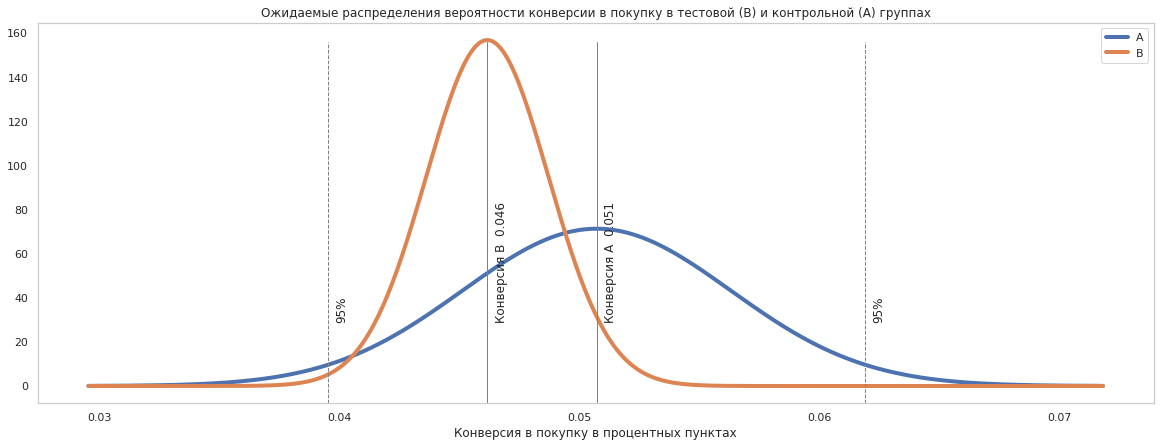

In [31]:
visualisation(test)